<a href="https://colab.research.google.com/github/artemk1337/SiameseCGAN-with-embedding-layers-and-contrastive-loss/blob/master/SiameseDCGAN_with_embedding_layers_and_contrastive_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing modules

In [ ]:
!!pip install -q pyyaml h5py

import tensorflow as tf
import tensorflow.keras.backend as K
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import (Dense, Conv2D, Conv2DTranspose, Flatten,
                                     MaxPool2D, GlobalAvgPool2D, LeakyReLU, 
                                     Reshape, Input, Embedding, multiply, 
                                     BatchNormalization, GlobalMaxPool2D,
                                     Lambda, Concatenate, Dropout)


import os
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load data

In [ ]:
# image shape
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

# noise vector length
z_dim = 100

## Image normalization
Выгружаем датасет MNIST и нормализуем изображения от 0. до 1.

In [ ]:
# load MNIST-dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")


def normalize_img(images):
    """
    Normalizes images: `uint8` -> `float32`.
    """
    return tf.cast(images, tf.float32) / 255.
    # return tf.cast(images, tf.float32) / 127.5 - 1


X_train = normalize_img(X_train)
X_test = normalize_img(X_test)

11493376/11490434 [==============================] - 0s 0us/step


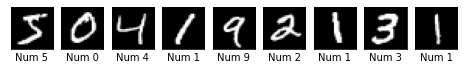

TensorShape([60000, 28, 28])

In [ ]:
plt.subplots(figsize=(8, 1)) 
for i in range(9):
    plt.subplot(1, 9, i+1)
    plt.xlabel(f"Num {y_train[i]}")
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

X_train.shape

# Data processing
Собираем новый датасет, наполовину состоящий из валидных пар изображений и невалидных пар. Валидными пары - картинки с одинаковыми числами, иные - невалидные.

In [ ]:
# samples with correct and incorrect image pairs
total_samples = 50000


# dict with each numeric-image index; example: {label: [indexes in data-array]}
def create_dict_index():
    d = {}
    for i, label in enumerate(y_train):
        if label not in d:
            d[label] = []
        d[label].append(i)
    return d


# create array with random labels
def create_labels(size_: int, prev_labels=None):
    labels = []
    min_ = min(list(label_index_dict.keys()))
    max_ = max(list(label_index_dict.keys()))
    # creating label array
    if prev_labels is None:
        for i in range(size_):
            labels.append(random.randint(min_, max_))
    # creatingarray with different random labels
    else:
        for i in range(size_):
            label = random.randint(min_, max_)
            while label == prev_labels[i]:
                label = random.randint(min_, max_)
            labels.append(label)
    return np.asarray(labels).reshape(-1, 1)


# create new X_train with random numeric-image index from label array
def create_img_array(labels: list, dict_: dict):
    imgs = np.ones(shape=(len(labels), *img_shape))
    for i, label in tqdm(enumerate(labels)):
        idx = dict_[label[0]][random.randint(0, len(dict_[label[0]]) - 1)]
        imgs[i] = np.reshape(X_train[idx], img_shape)
    return imgs


label_index_dict = create_dict_index()

# creating label arrays
labels_true = create_labels(total_samples//2)
labels_false = create_labels(total_samples//2, labels_true)
labels_left = np.concatenate((labels_true, labels_true))
labels_right = np.concatenate((labels_true, labels_false))
print(labels_left.shape, labels_right.shape)

# creating X_train
X_left = create_img_array(labels_left, label_index_dict)
print(X_left.shape)
X_right = create_img_array(labels_right, label_index_dict)
print(X_right.shape)

321it [00:00, 3207.09it/s]

(50000, 1) (50000, 1)


50000it [00:15, 3134.98it/s]
291it [00:00, 2903.95it/s]

(50000, 28, 28, 1)


50000it [00:16, 3119.18it/s]

(50000, 28, 28, 1)


In [ ]:
# creating y_train
y_true = np.ones(shape=(total_samples//2, 1))
y_false = np.zeros(shape=(total_samples//2, 1))
y_train = np.concatenate((y_true, y_false))

## Shuffle data
Перемешиваем датасет. Т.к. массивов данных несколько, удобнее всего перемешивать по индексам и сразу конвертировать в `tf.Tensor`.

In [ ]:
indices = tf.range(start=0, limit=total_samples, dtype=tf.int32)
idx = tf.random.shuffle(indices)

X_left = tf.gather(X_left, idx)
X_right = tf.gather(X_right, idx)
labels_left = tf.gather(labels_left, idx)
labels_right = tf.gather(labels_right, idx)
y_train = np.array(tf.gather(y_train, idx))

# Build models

## Build generator
Generator получает на вход вектор шума длиной 100 и `label` желаемого числа. Аналогичным способом можно подавать в качестве `label` не только целое число, но и тензор любой размерности. Например, слова, преобразованные с помощью модели `Word2Vec` (в таком случае слой `Embedding` не нужен).  
Кроме того, применив метод обучения без учителя с помощью модели `PCA (principal component analysis)` и одной из моделей кластеризации можно разбить данные на малые выборки. Такая модель дает возможность отличать, например, наклон, шрифт или другие характерные признаки изображения.  
На этом этапе возможно создать новый датасет и увеличить влияние `label` на generator (увеличить вектор признаков), что позволит более точно генерировать желаемые изображения.

In [ ]:
def build_generator(img_shape: tuple, z_dim: int):
    # building 2D-model
    model = Sequential()

    model.add(Dense(7*7*512, input_dim=z_dim))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Reshape((7, 7, 512)))
    model.add(Conv2DTranspose(256, 4, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(128, 4, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # sigmoid activation if    IMAGE / 255
    # tanh activation if       IMAGE / 127.5 - 1
    model.add(Conv2DTranspose(1, channels, strides=1, padding='same',
                              name='IMG_Output', activation='sigmoid'))
    assert model.output.shape[1:] == img_shape,\
      f"Output shape must be {img_shape}, but is {model.layers[-1].shape}"
    return model


# embedding layer allow to generate desired numeric-image
def create_embedding_g(output_dim: int):
    # embedding layers
    label = Input(shape=(1,), dtype='int32', name='Label_Input')
    label_embedding = Embedding(10, output_dim)(label)
    label_embedding = Flatten()(label_embedding)
    return label, label_embedding


def build_generator_embedding(img_shape: tuple):
    # noise input
    z = Input(shape=(z_dim,), name='Noise_Input')

    generator = build_generator(img_shape, z_dim)
    # generator.summary()

    label, label_embedding = create_embedding_g(z_dim)

    # layers merging
    img = generator(multiply([z, label_embedding]))

    # build model
    generator = Model([z, label], img, name='Generator')
    generator.summary()

    return generator

## Build discriminator
Discriminator получает на вход изображение и преобразует его в вектор признаков. Пропустив два разных изображения через модель получим два вектора, которые в дальнейшем нужно сравнить.  
Изначально мы поэлементно рассчитывали модуль разности между двумя векторами, получая новый вектор такого же размера, после чего использовали слой `Dense` с одним выходом и функцией активации `tanh`. В другом случае мы немного пересобрали модель: применили `Lambda`-функцию для рассчета евклидовой дистанции между векторами и убрали слой `Dense`. Сравнив оба метода по скорости обучения GAN-сети и качестве работы generator, мы пришли к выводу, что второй способ гораздо эффективнее первого.  

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def build_discriminator(img_shape: tuple, output_dim: int, header=True):
    # building 2D-model
    input = Input(shape=(img_shape))

    model = Conv2D(128, 4, strides=2, padding='same')(input)
    #model = BatchNormalization()(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.2)(model)
    
    model = Conv2D(256, 4, strides=2, padding='same')(model)
    #model = BatchNormalization()(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.2)(model)
    
    model = Conv2D(512, 4, strides=2, padding='same')(model)
    #model = BatchNormalization()(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = GlobalMaxPool2D()(model)
    model_d = Model(input, model)

    if header is True:
        model = Dense(output_dim,
                          activation='tanh',
                          name='Vector_Output')(model)
        """model_cl = Dense(128, activation='relu')(model)
        model_cl = Dense(1,
                         activation='sigmoid',
                         name='Classificator_Output')(model_cl)"""
        return model_d, Model(input, model)
    return model_d, None
    


def build_discriminator_embedding(img_shape: tuple):
    output_dim = 64
    model_d, model_vec = build_discriminator(img_shape, output_dim, True)
    # model_discriminator.summary()

    img_d_left = Input(shape=(img_shape), name='Left_Img_Input')
    img_d_right = Input(shape=(img_shape), name='Right_Img_Input')

    output_left = model_vec(img_d_left)
    output_right = model_vec(img_d_right)

    discriminator = Model(img_d_left, model_d(img_d_left), name='Discriminator')

    # version 1 for "binary_crossentropy" loss
    """
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([output_left, output_right])
    prediction = Dense(1, activation='sigmoid')(L1_distance)
    siamese_net = Model([img_d_left, img_d_right],
                        prediction)
    """

    # version 2 for contrastive loss; work perfect
    distance = Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([output_left, output_right])
    siamese_net = Model([img_d_left, img_d_right],
                        distance)

    siamese_net.summary()
    return siamese_net, model_vec, discriminator

# siamese_net, vec_model, model_cl = build_discriminator_embedding(img_shape)

## Build GAN
Собмраем GAN-сеть. На вход подается вектор шума, `label` и реальное изображение. На выходе евклидова дистанция между векторами.

In [ ]:
def build_SiameseDCGAN(generator, discriminator, z_dim):
    discriminator.trainable = False

    gan_input_dim = Input(shape=(z_dim,), name='Noise_Input')
    gan_input_label = Input(shape=(1,), dtype='int32', name='Label_Input')
    img_real = Input(shape=(img_shape), name='IMG_Input')

    # gan input
    gan_input = [gan_input_dim, img_real, gan_input_label]

    # generator output image
    x = generator([gan_input_dim, gan_input_label])

    # gan output
    gan_output = discriminator([x, img_real])

    # build model
    gan = Model(inputs=gan_input, outputs=gan_output, name='SiameseCGAN')
    gan.summary()
    return gan

# Compile models
Создаем и компилируем модели.  
Стоит обратить внимание:
1. Generator не компилируется.
2. Важно сохранять порядок! Сначала компилируем discriminator, а после создаем GAN-сеть.

In [ ]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

generator = build_generator_embedding(img_shape)

siamese_net, vec_model, model_d = build_discriminator_embedding(img_shape)

# the larger the batch, the larger the step and the momentum
optimizer = Adam(lr=0.00025, beta_1=0.5)
### For V1 loss: 'binary_crossentropy'
siamese_net.compile(optimizer=optimizer, loss=contrastive_loss, metrics=['binary_accuracy'])

cgan = build_SiameseDCGAN(generator, siamese_net, z_dim)

# the larger the batch, the larger the step and the momentum
optimizer = Adam(lr=0.00025, beta_1=0.5)
### For V1 loss: 'binary_crossentropy'
cgan.compile(optimizer=optimizer, loss=contrastive_loss, metrics=['binary_accuracy'])

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Label_Input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 100)       1000        Label_Input[0][0]                
__________________________________________________________________________________________________
Noise_Input (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 100)          0           embedding_3[0][0]                
__________________________________________________________________________________________

# Fit models

Epoch 1
Processed 10000/50000; [0.1183912567794323]; [0.397490918636322]


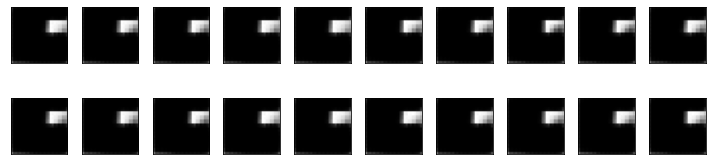

Processed 20000/50000; [0.10276583209633827]; [0.355327308177948]


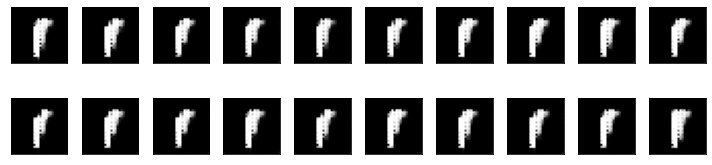

Processed 30000/50000; [0.1000933051109314]; [0.3749600648880005]


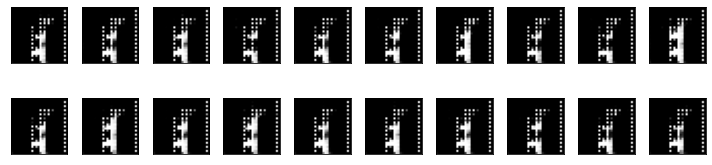

Processed 40000/50000; [0.09354298561811447]; [0.3473992943763733]


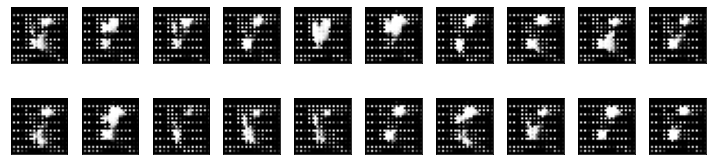

Processed 50000/50000; [0.09577278792858124]; [0.38904160261154175]


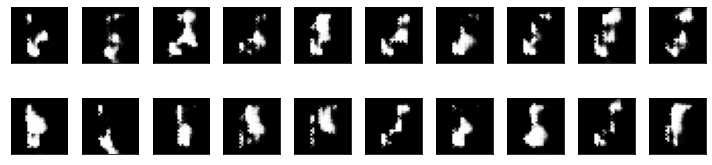

Epoch 2
Processed 10000/50000; [0.08864638581871986]; [0.3459801971912384]


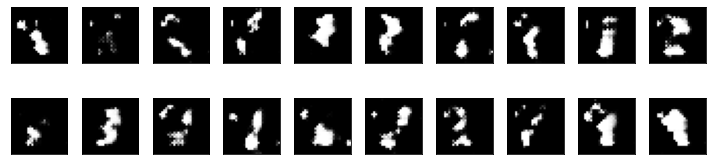

Processed 20000/50000; [0.08469241112470627]; [0.33797508478164673]


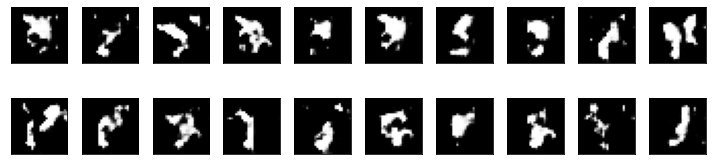

Processed 30000/50000; [0.08320721052587032]; [0.3228444755077362]


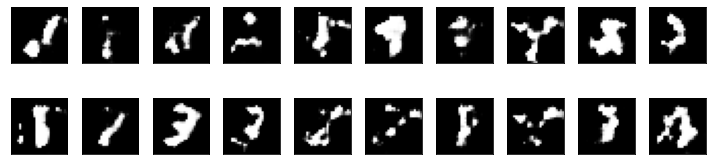

Processed 40000/50000; [0.08548540621995926]; [0.31834983825683594]


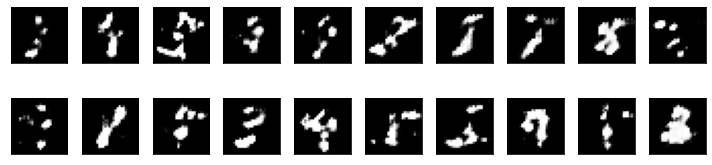

Processed 50000/50000; [0.08704292215406895]; [0.30662664771080017]


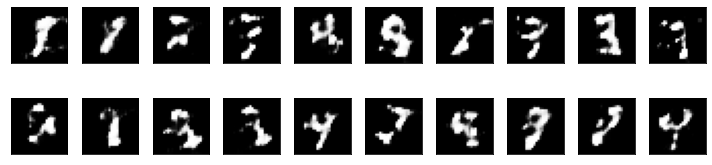

Epoch 3
Processed 10000/50000; [0.08564931154251099]; [0.2356872409582138]


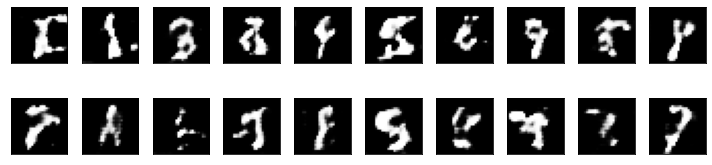

Processed 20000/50000; [0.08242597617208958]; [0.23602671921253204]


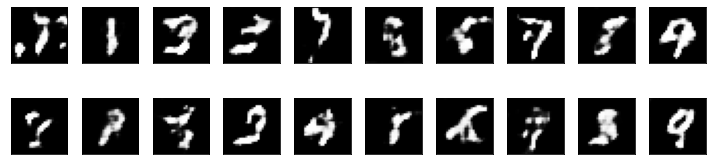

Processed 30000/50000; [0.08576130121946335]; [0.20865043997764587]


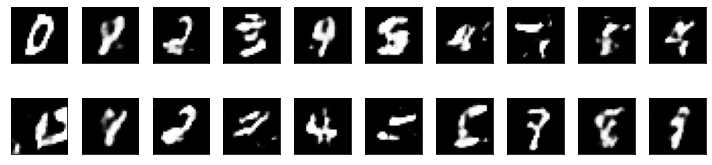

Processed 40000/50000; [0.0861175935715437]; [0.17817747592926025]


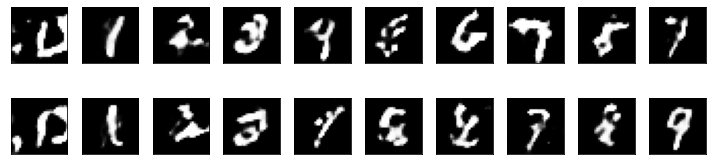

Processed 50000/50000; [0.09483043290674686]; [0.16490690410137177]


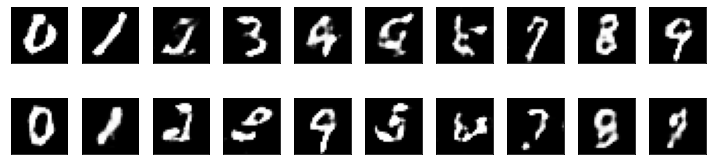

Epoch 4
Processed 10000/50000; [0.08862013928592205]; [0.13212189078330994]


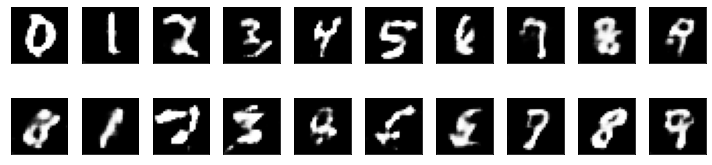

Processed 20000/50000; [0.0841586273163557]; [0.11487197130918503]


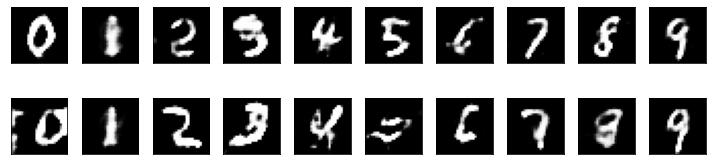

Processed 30000/50000; [0.090001679956913]; [0.10442908108234406]


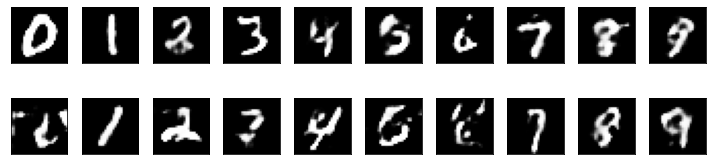

Processed 40000/50000; [0.09291114658117294]; [0.10337185859680176]


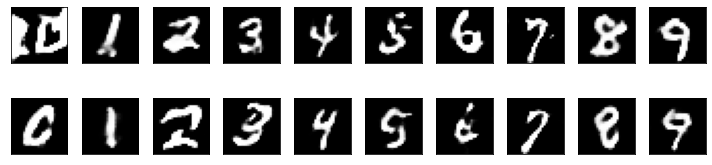

Processed 50000/50000; [0.09570408053696156]; [0.09762698411941528]


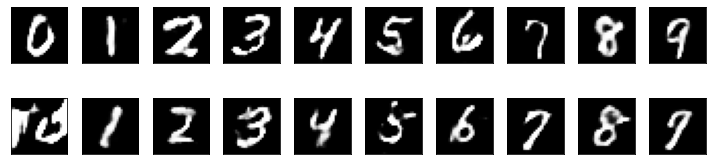

Epoch 5
Processed 10000/50000; [0.08325115963816643]; [0.06794771552085876]


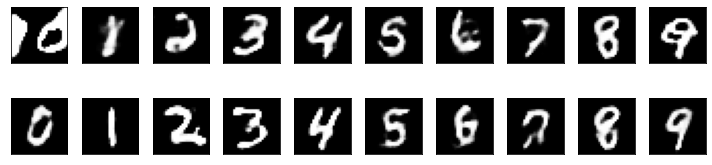

Processed 20000/50000; [0.08430152200162411]; [0.07550829648971558]


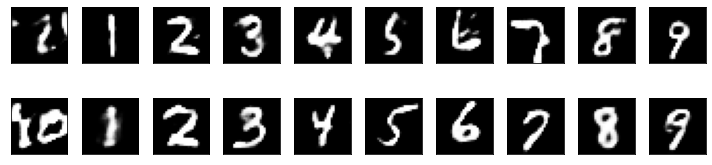

Processed 30000/50000; [0.08877980895340443]; [0.07133188098669052]


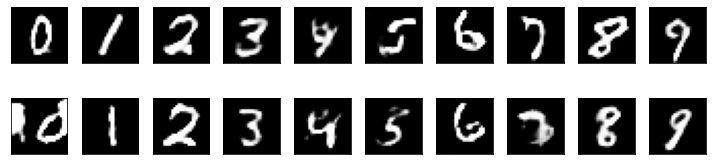

Processed 40000/50000; [0.08737128041684628]; [0.07118658721446991]


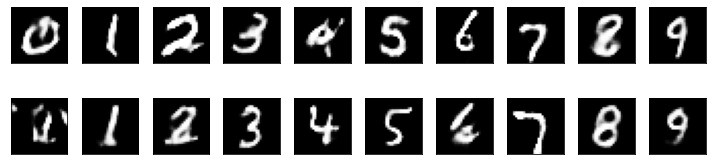

Processed 50000/50000; [0.0876556895673275]; [0.06651407480239868]


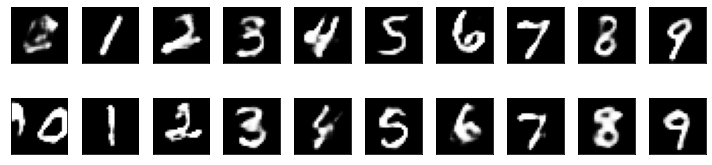

Epoch 6
Processed 10000/50000; [0.08608070015907288]; [0.0606377087533474]


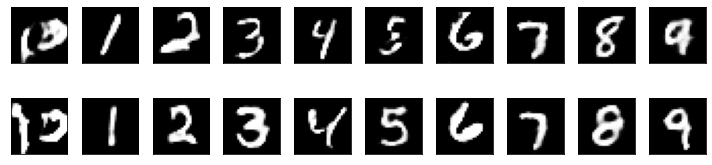

Processed 20000/50000; [0.09288294240832329]; [0.06093059852719307]


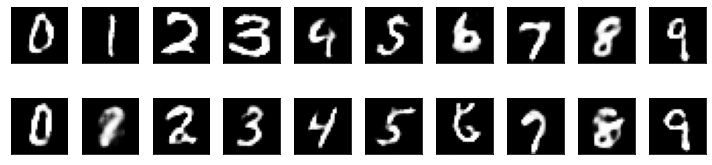

Processed 30000/50000; [0.08510285802185535]; [0.05327313393354416]


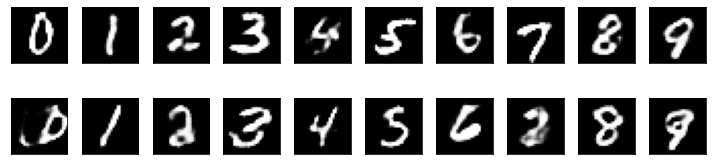

Processed 40000/50000; [0.08886228129267693]; [0.05858870968222618]


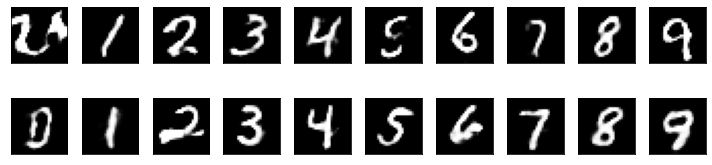

Processed 50000/50000; [0.0901696253567934]; [0.06059419736266136]


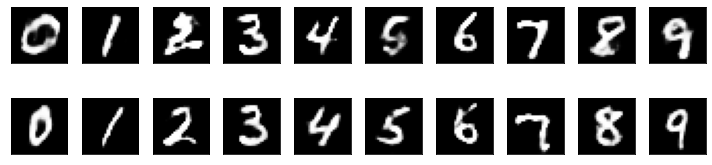

Epoch 7
Processed 10000/50000; [0.08507970720529556]; [0.052744146436452866]


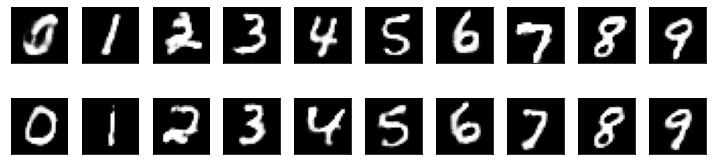

Processed 20000/50000; [0.0872236117720604]; [0.046350084245204926]


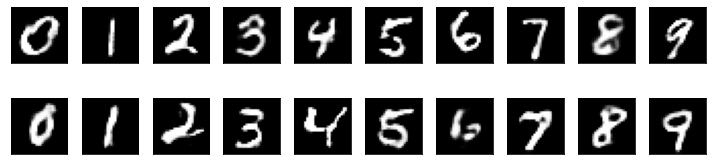

Processed 30000/50000; [0.08785450085997581]; [0.04806690290570259]


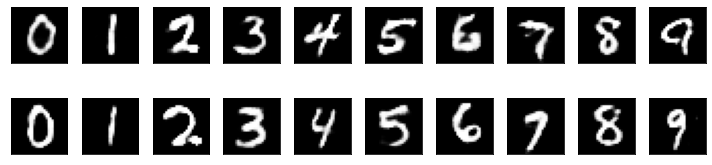

Processed 40000/50000; [0.09823385812342167]; [0.053833283483982086]


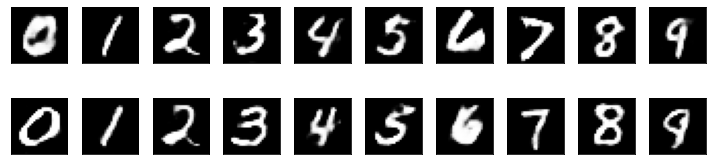

Processed 50000/50000; [0.08150976710021496]; [0.043135594576597214]


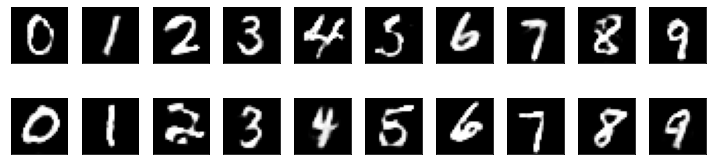

Epoch 8
Processed 10000/50000; [0.09626794047653675]; [0.04896492138504982]


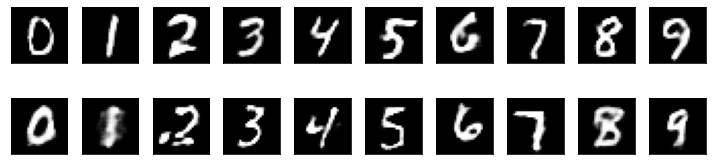

Processed 20000/50000; [0.08515230193734169]; [0.04366789013147354]


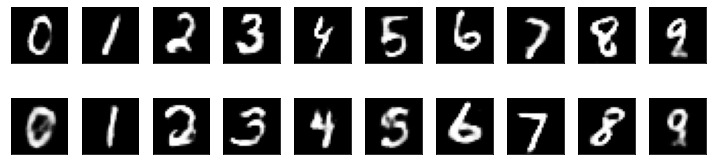

Processed 30000/50000; [0.08630898036062717]; [0.04666297510266304]


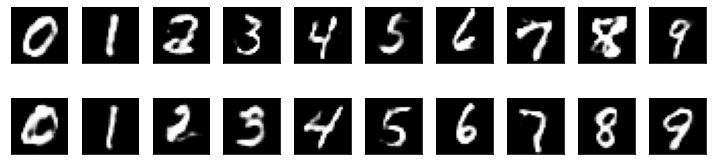

Processed 40000/50000; [0.08495246805250645]; [0.04781496152281761]


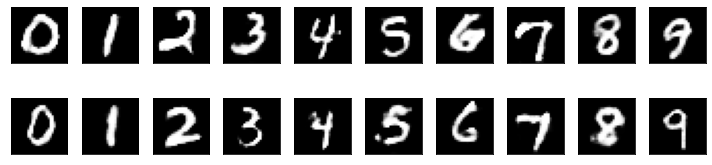

Processed 50000/50000; [0.08624875918030739]; [0.04568801447749138]


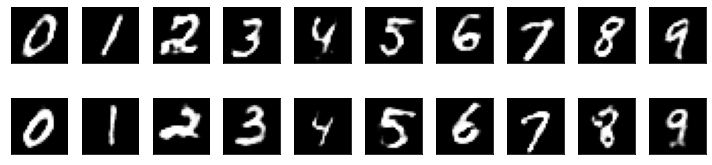

Epoch 9
Processed 10000/50000; [0.08175406232476234]; [0.040840934962034225]


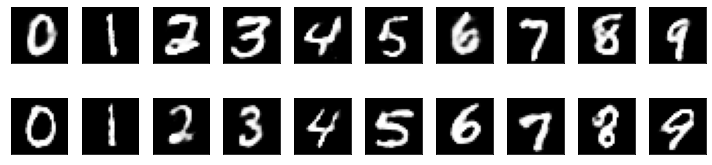

Processed 20000/50000; [0.09050517529249191]; [0.037774600088596344]


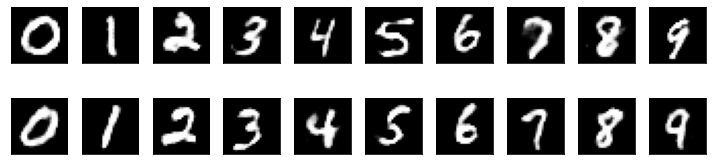

Processed 30000/50000; [0.07915792241692543]; [0.03700554370880127]


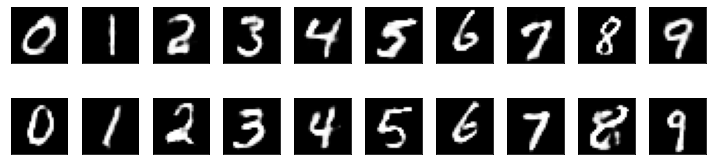

Processed 40000/50000; [0.10038183070719242]; [0.04323824495077133]


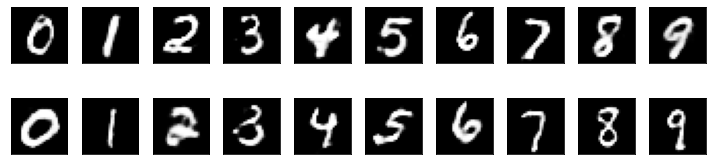

Processed 50000/50000; [0.08520383574068546]; [0.0421249121427536]


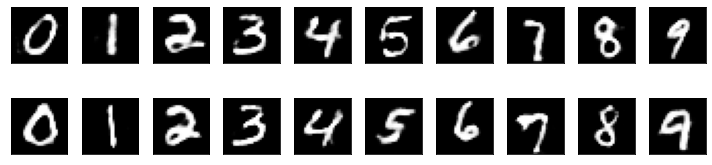

Epoch 10
Processed 10000/50000; [0.08348720893263817]; [0.04005320370197296]


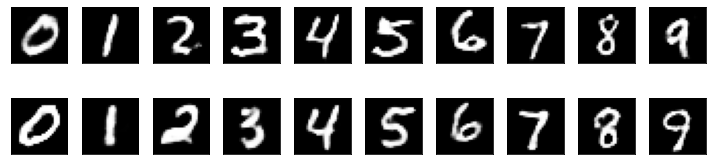

Processed 20000/50000; [0.08740309253334999]; [0.0347464457154274]


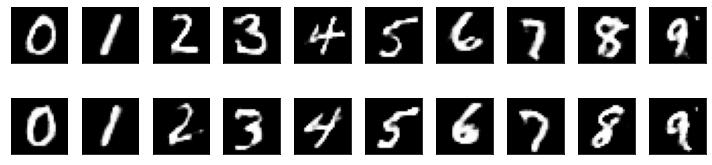

Processed 30000/50000; [0.08911852911114693]; [0.03852976858615875]


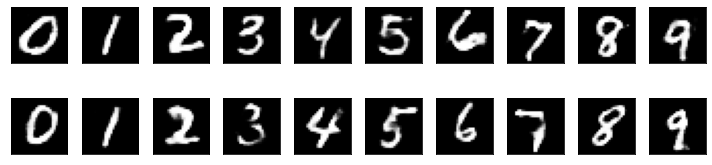

Processed 40000/50000; [0.08897899650037289]; [0.044360872358083725]


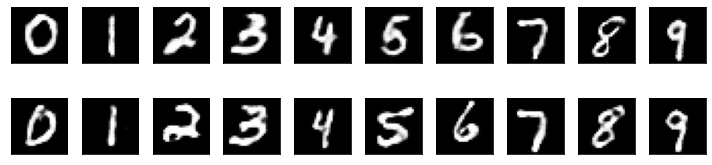

Processed 50000/50000; [0.08428317494690418]; [0.04311508312821388]


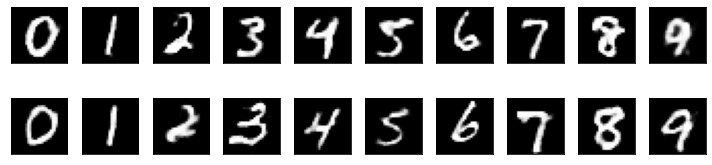

Epoch 11
Processed 10000/50000; [0.08229289017617702]; [0.03680126741528511]


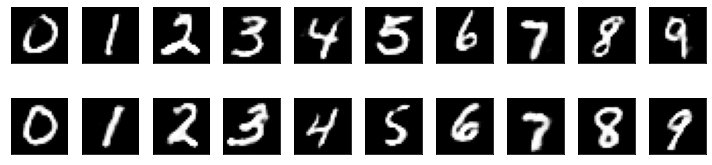

Processed 20000/50000; [0.09448260627686977]; [0.03464221581816673]


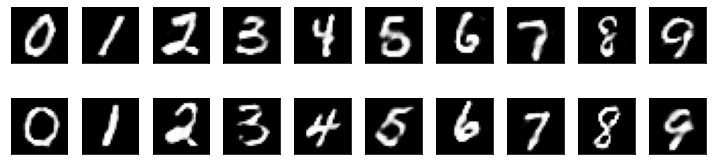

Processed 30000/50000; [0.0928974598646164]; [0.03651908040046692]


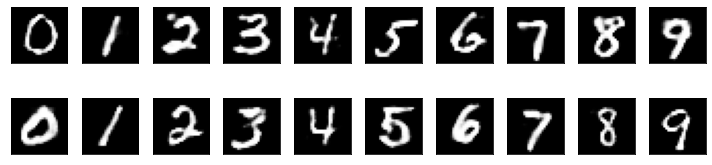

Processed 40000/50000; [0.08635643869638443]; [0.04031684249639511]


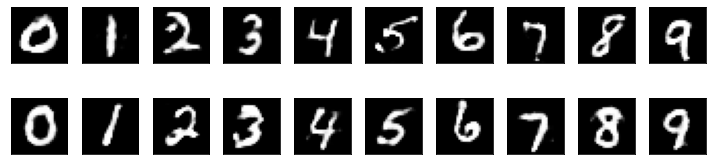

Processed 50000/50000; [0.07980753108859062]; [0.04065139219164848]


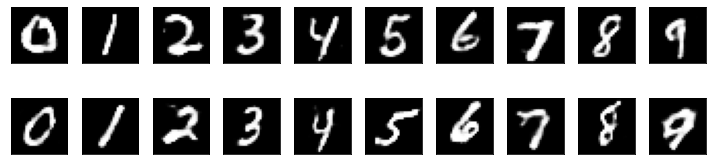

Epoch 12
Processed 10000/50000; [0.08490570075809956]; [0.0360160656273365]


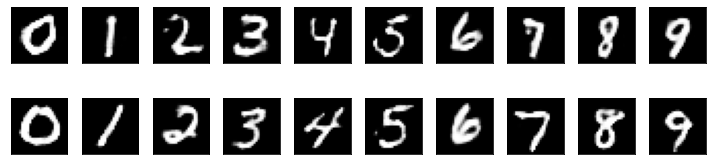

Processed 20000/50000; [0.09813244361430407]; [0.03082008846104145]


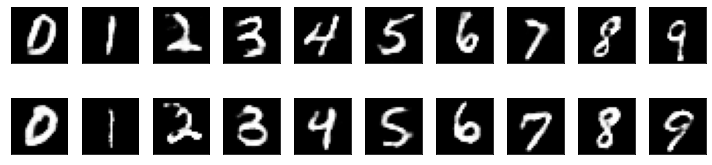

Processed 30000/50000; [0.091710957698524]; [0.03400256484746933]


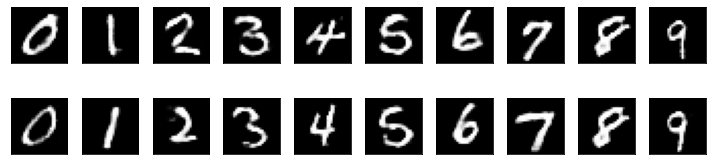

Processed 40000/50000; [0.0894438810646534]; [0.03542618080973625]


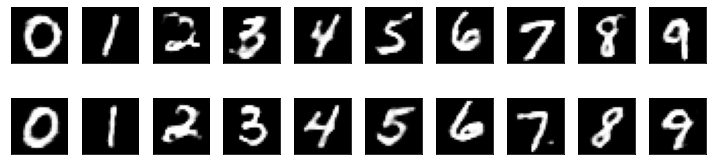

Processed 50000/50000; [0.08296061679720879]; [0.03503552824258804]


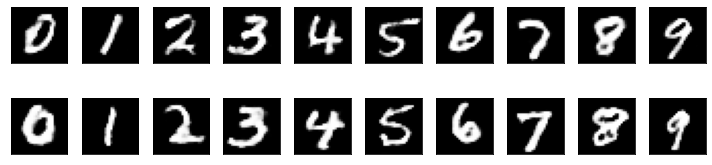

Epoch 13
Processed 10000/50000; [0.08273951336741447]; [0.033011846244335175]


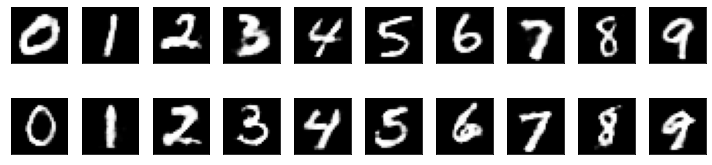

Processed 20000/50000; [0.07661128044128418]; [0.029344841837882996]


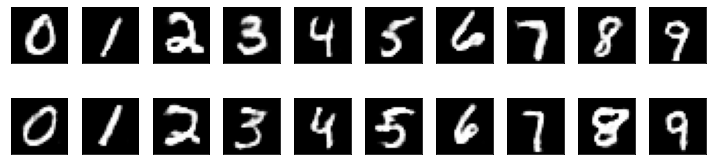

Processed 30000/50000; [0.08633457031100988]; [0.034110501408576965]


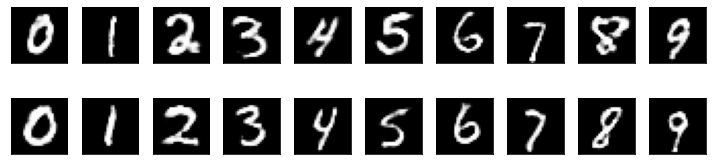

Processed 40000/50000; [0.09121236763894558]; [0.032212622463703156]


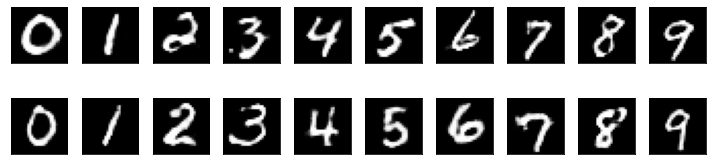

Processed 50000/50000; [0.07983301859349012]; [0.036770306527614594]


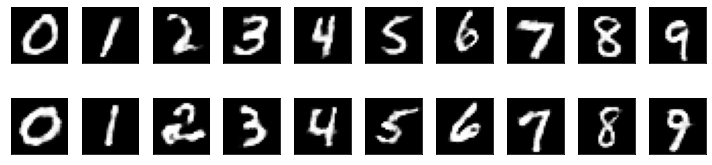

Epoch 14
Processed 10000/50000; [0.08489846531301737]; [0.03301532194018364]


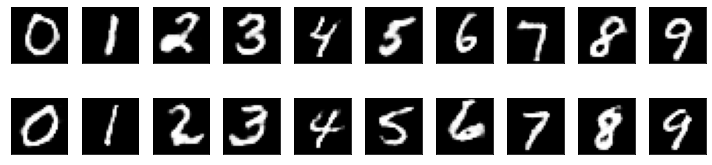

Processed 20000/50000; [0.07466987427324057]; [0.027432506904006004]


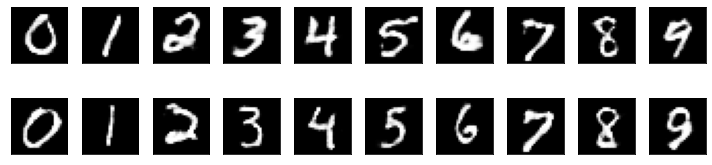

Processed 30000/50000; [0.08059027511626482]; [0.029689814895391464]


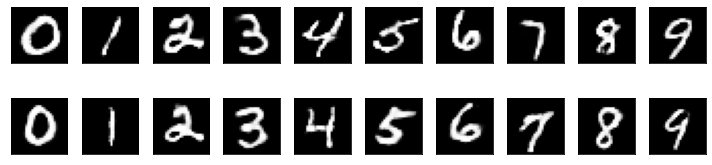

Processed 40000/50000; [0.0837037991732359]; [0.03086087666451931]


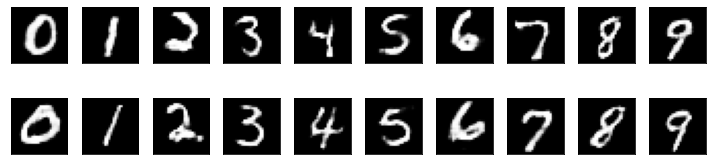

Processed 50000/50000; [0.08077946491539478]; [0.034740909934043884]


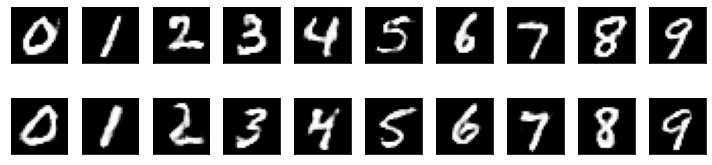

Epoch 15
Processed 10000/50000; [0.08104942087084055]; [0.03220758214592934]


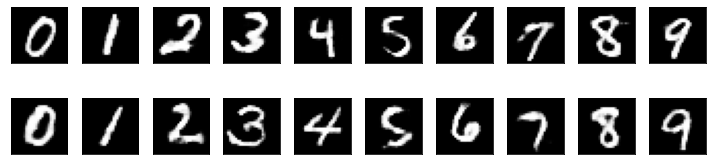

Processed 20000/50000; [0.08451367914676666]; [0.02711700275540352]


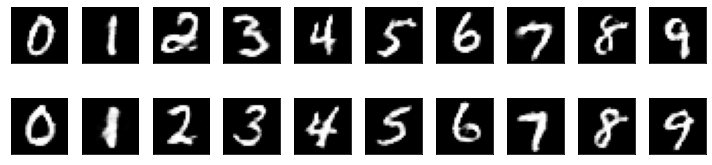

Processed 30000/50000; [0.07829157914966345]; [0.03173641115427017]


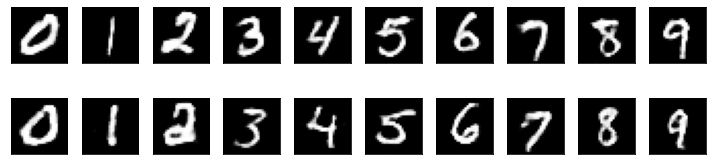

Processed 40000/50000; [0.08636556938290596]; [0.03235176205635071]


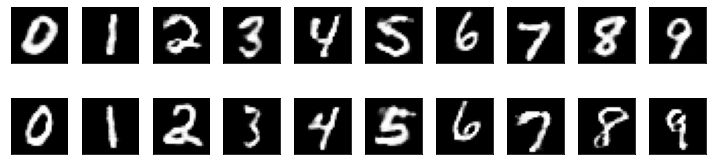

Processed 50000/50000; [0.07629637978971004]; [0.03371823951601982]


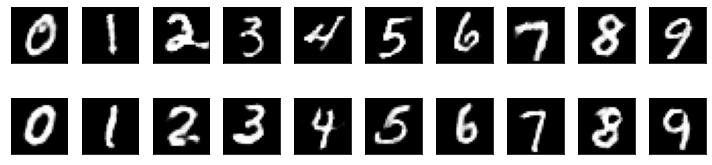

Epoch 16
Processed 10000/50000; [0.08487136848270893]; [0.030734019353985786]


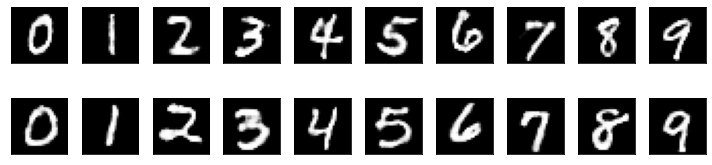

Processed 20000/50000; [0.08553117234259844]; [0.028439246118068695]


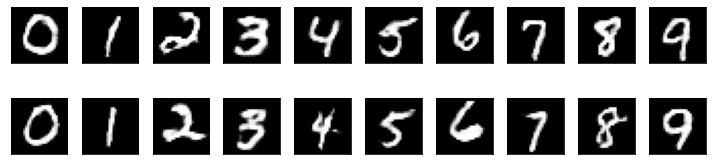

Processed 30000/50000; [0.0779948178678751]; [0.032857704907655716]


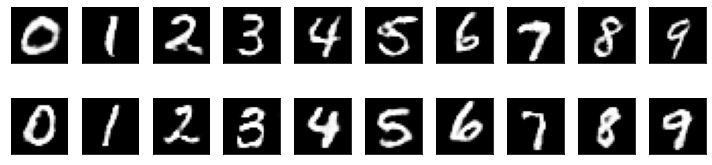

Processed 40000/50000; [0.0842125192284584]; [0.03188566491007805]


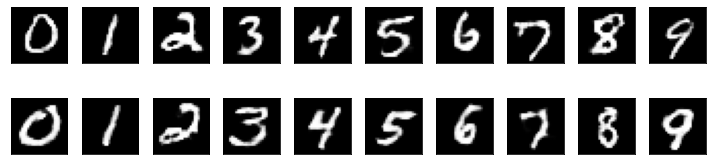

Processed 50000/50000; [0.08271368965506554]; [0.033877309411764145]


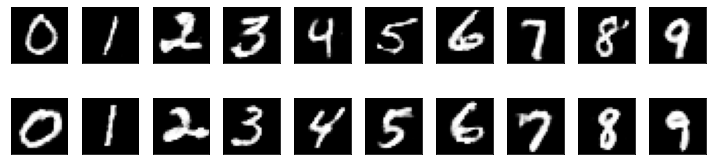

Epoch 17
Processed 10000/50000; [0.08749531861394644]; [0.03178922459483147]


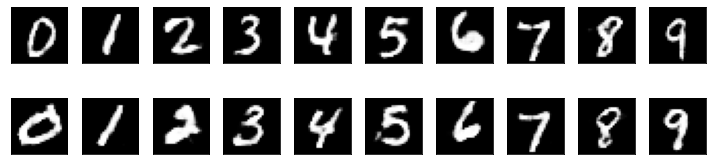

Processed 20000/50000; [0.08030188642442226]; [0.029099982231855392]


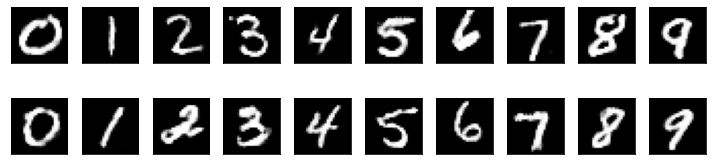

Processed 30000/50000; [0.0847250372171402]; [0.02854315936565399]


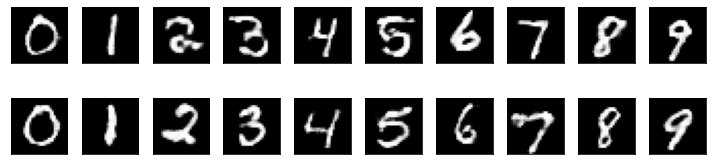

Processed 40000/50000; [0.08520715311169624]; [0.032351378351449966]


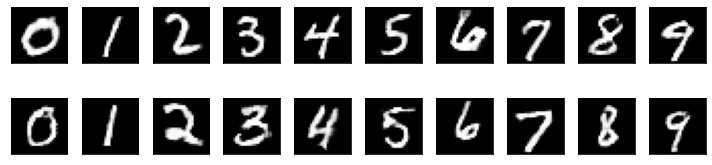

Processed 50000/50000; [0.08366715349256992]; [0.029738275334239006]


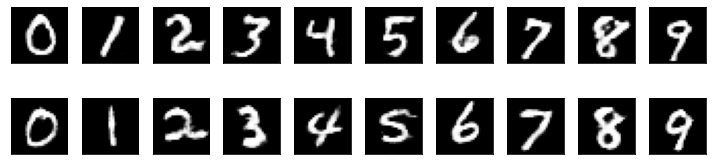

Epoch 18
Processed 10000/50000; [0.08096342626959085]; [0.03026353195309639]


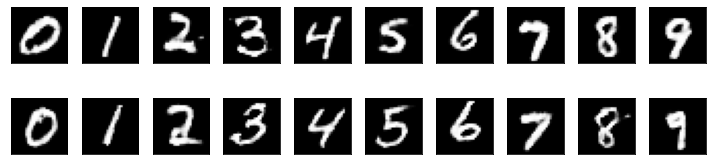

Processed 20000/50000; [0.08169976901262999]; [0.02591395378112793]


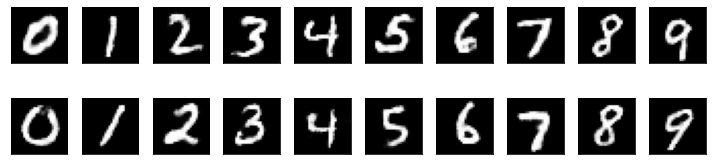

Processed 30000/50000; [0.07841478567570448]; [0.028017327189445496]


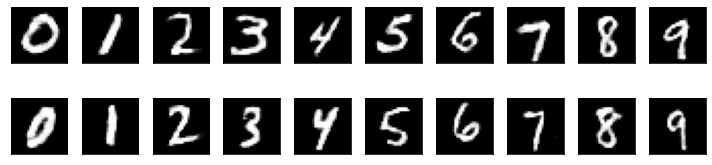

Processed 40000/50000; [0.0754256583750248]; [0.028780948370695114]


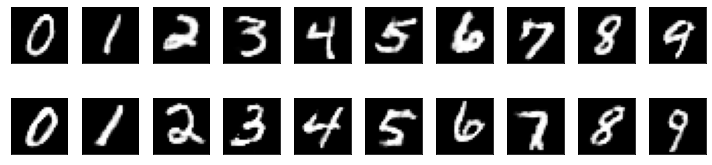

Processed 50000/50000; [0.08857961371541023]; [0.028756778687238693]


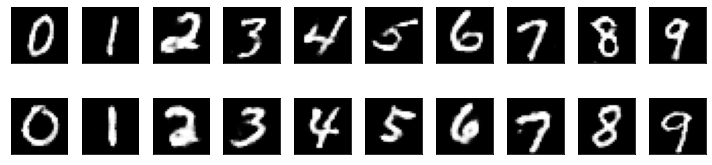

Epoch 19
Processed 10000/50000; [0.07927575800567865]; [0.028991706669330597]


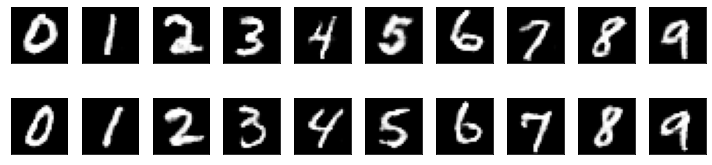

Processed 20000/50000; [0.07767327409237623]; [0.023441068828105927]


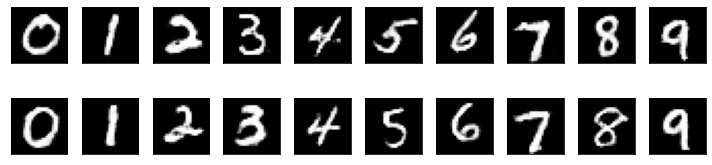

Processed 30000/50000; [0.08356901630759239]; [0.026621300727128983]


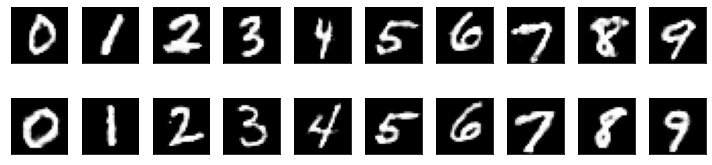

Processed 40000/50000; [0.09572636988013983]; [0.02881459705531597]


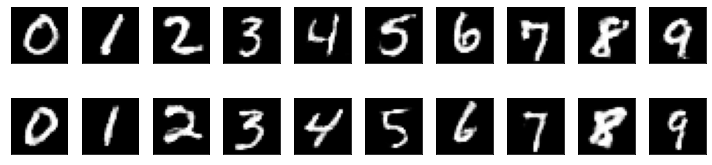

Processed 50000/50000; [0.09288420900702477]; [0.027168231084942818]


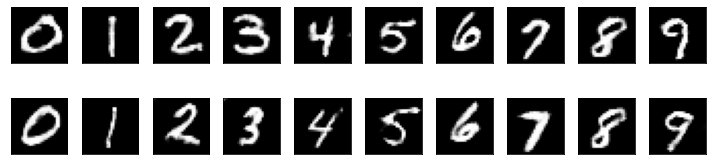

Epoch 20
Processed 10000/50000; [0.08588475920259953]; [0.027994200587272644]


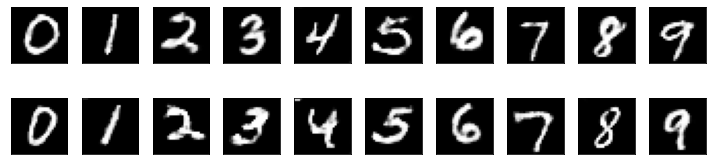

Processed 20000/50000; [0.08514206670224667]; [0.025029797106981277]


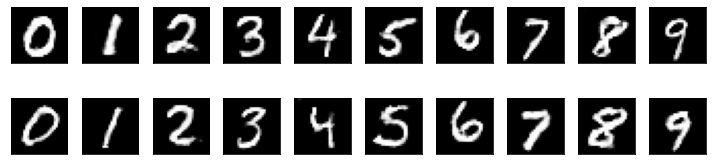

Processed 30000/50000; [0.07748030498623848]; [0.02721046470105648]


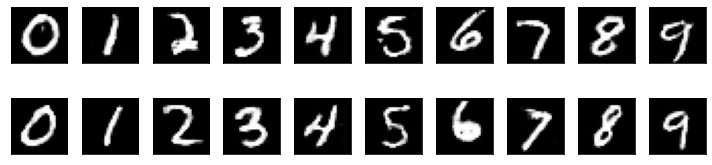

Processed 40000/50000; [0.08030558843165636]; [0.03009658493101597]


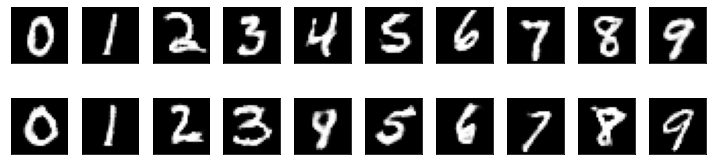

Processed 50000/50000; [0.08304449077695608]; [0.028810052201151848]


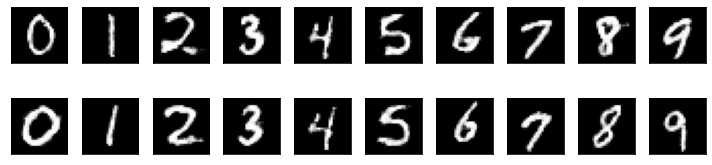

In [ ]:
batch_size = 200  # 200
epochs = 20
# margin helps the models fitting better at the start
margin = 0.1

D_LOSS = []
G_LOSS = []


# creating noise-array
def create_noise_array(size_arr):
    return np.random.normal(loc=0, scale=1, size=(size_arr, z_dim))


for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    step = 0
    while (step + 1) * batch_size <= total_samples:

        # training discriminator
        discriminant_loss = 0
        additional_batch = batch_size
        start_index = step*batch_size
        final_index = start_index + additional_batch

        siamese_net.trainable = True
        d_loss = siamese_net.train_on_batch(x=[X_left[start_index:final_index],
                                                 X_right[start_index:final_index]],
                                              y=y_train[start_index:final_index])
        discriminant_loss += 0.5 * d_loss[0]

        
        X_fake = generator.predict_on_batch([create_noise_array(additional_batch),
                                             np.random.randint(0, 10, additional_batch).reshape(-1, 1)])
        d_loss = siamese_net.train_on_batch(x=[X_fake,
                                                 X_right[start_index:final_index]],
                                              y=tf.abs(y_false[:additional_batch] - margin))
        discriminant_loss += 0.5 * d_loss[0]
        D_LOSS += [discriminant_loss]
        
        # training generator
        additional_batch = batch_size
        start_index = step*batch_size
        final_index = start_index + additional_batch

        siamese_net.trainable = False
        g_loss = cgan.train_on_batch(x=[create_noise_array(additional_batch),
                                        X_right[start_index:final_index],
                                        labels_left[start_index:final_index]],
                                     y=y_train[start_index:final_index])[0]
        G_LOSS += [g_loss]
        step += 1

        if step % 50 == 0:
            print(f"Processed {(step)*batch_size}/{total_samples}; {[discriminant_loss]}; {[g_loss]}")

            samples = 20
            z = np.random.normal(loc=0, scale=1, size=(samples, z_dim))
            labels = np.concatenate((np.arange(0, 10).reshape(-1, 1), np.arange(0, 10).reshape(-1, 1)), axis=0)
            x_fake = generator.predict([z, labels])
            plt.figure(figsize=(10,3))
            for k in range(samples):
                plt.subplot(2, 10, k+1)
                plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
                plt.xticks([])
                plt.yticks([])
            plt.tight_layout()
            # plt.savefig('./' + f'{e}_epoch.png')
            plt.show()


# Evaluate generator and discriminator

Преобразование изображения в вектор признаков

In [ ]:
img = generator.predict([np.random.normal(loc=0, scale=1, size=(1, z_dim)), np.array([random.randint(0, 9)]).reshape(-1, 1)])
vec_model.predict(img).shape

(1, 64)

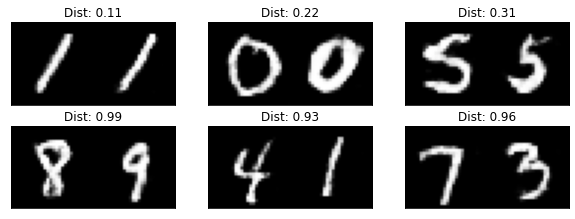

In [ ]:
def distance_predicted_img(hor: int, ver: int, num: int, a: int, b: int):
    
    img_a = generator.predict([np.random.normal(loc=0, scale=1, size=(1, z_dim)), np.array([a]).reshape(-1, 1)])
    a = vec_model.predict(img_a)
    img_b = generator.predict([np.random.normal(loc=0, scale=1, size=(1, z_dim)), np.array([b]).reshape(-1, 1)])
    b = vec_model.predict(img_b)

    img_a, img_b = img_a.reshape(28, 28), img_b.reshape(28, 28)
    plt.subplot(hor, ver, num)
    plt.title(f"Dist: {round(float(tf.norm(a - b)), 2)}")
    plt.imshow(np.concatenate((img_a, img_b), axis=1), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    


plt.subplots(figsize=(10, 3.5)) 

distance_predicted_img(2, 3, 1, 1, 1)
distance_predicted_img(2, 3, 2, 0, 0)
distance_predicted_img(2, 3, 3, 5 ,5)

distance_predicted_img(2, 3, 4, 8, 9)
distance_predicted_img(2, 3, 5, 4, 1)
distance_predicted_img(2, 3, 6, 7, 3)
plt.show()

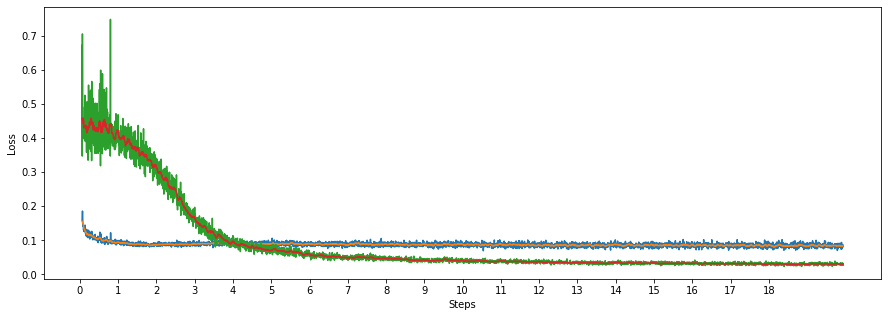

In [ ]:
def smooth(y, box_pts=15):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.subplots(figsize=(15, 5))
plt.plot([i for i in range(len(D_LOSS))][15:-15], D_LOSS[15:-15])
plt.plot([i for i in range(len(D_LOSS))][15:-15], smooth(D_LOSS)[15:-15])
plt.plot([i for i in range(len(G_LOSS))][15:-15], G_LOSS[15:-15])
plt.plot([i for i in range(len(G_LOSS))][15:-15], smooth(G_LOSS)[15:-15])
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.xticks([i*(total_samples // batch_size) for i in range(epoch)], [i for i in range(epoch)])
plt.show()

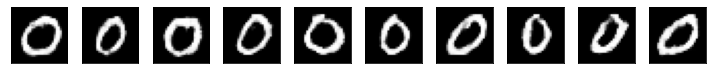

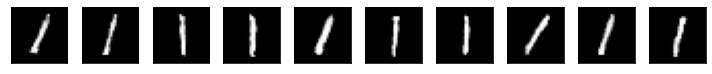

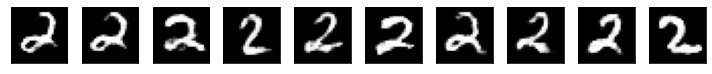

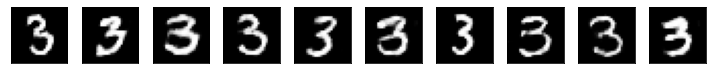

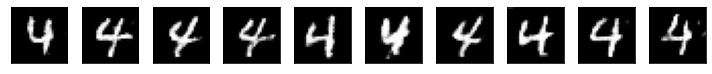

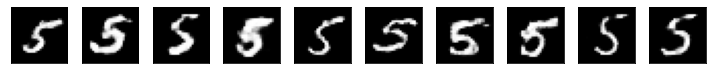

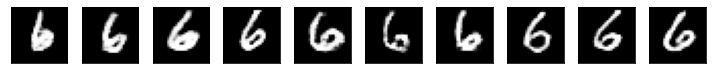

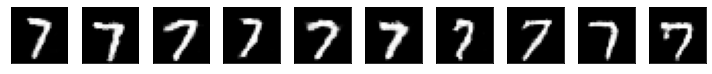

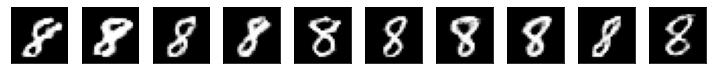

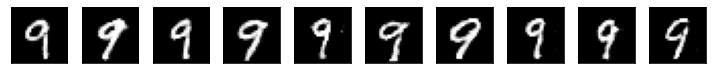

In [ ]:
samples = 10
z = np.random.normal(loc=0, scale=1, size=(samples, z_dim))
for i in range(samples):
    labels = np.zeros((samples, 1)) + i
    x_fake = generator.predict([z, labels])
    plt.figure(figsize=(10,2))
    for k in range(samples):
        plt.subplot(1, 10, k+1)
        plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    # plt.savefig('./' + f'{e}_epoch.png')
    plt.show()

# Save models

In [ ]:
siamese_net.save('siamese_discriminator.h5')
vec_model.save('vec_discriminator.h5')
model_d.save('base_discriminator.h5')

generator.save('generator.h5')

# Classifier model on convolutional base

# Compile models
Создаем и компилируем модели.

In [ ]:
model_d.trainable = False

model_cl = Sequential(model_d)
model_cl.add(Dense(256, activation='relu'))
model_cl.add(Dense(1, activation='sigmoid'))

model_cl.summary()

optimizer = Adam()
model_cl.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Discriminator (Functional)   (None, 512)               2624384   
_________________________________________________________________
dense_68 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 257       
Total params: 2,755,969
Trainable params: 131,585
Non-trainable params: 2,624,384
_________________________________________________________________


# Fit models

In [ ]:
batch_size = 200  # 200
epochs = 100
# margin helps the models fitting better at the start
margin = 0.1

D_LOSS = []
G_LOSS = []


# creating noise-array
def create_noise_array(size_arr):
    return np.random.normal(loc=0, scale=1, size=(size_arr, z_dim))




for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    step = 0
    while (step + 1) * batch_size <= total_samples:

        # training discriminator
        discriminant_loss = 0
        additional_batch = batch_size
        start_index = step*batch_size
        final_index = start_index + additional_batch

        d_loss = model_cl.train_on_batch(x=X_left[start_index:final_index],
                                         y=y_true[:additional_batch])
        discriminant_loss += 0.5 * d_loss[0]

        X_fake = generator.predict_on_batch([create_noise_array(additional_batch),
                                             np.random.randint(0, 10, additional_batch).reshape(-1, 1)])
        d_loss = model_cl.train_on_batch(x=X_fake,
                                         y=y_false[:additional_batch])
        discriminant_loss += 0.5 * d_loss[0]
        step += 1
        if step % 10 == 0:
            print(f"Processed {(step)*batch_size}/{total_samples}; {[discriminant_loss]}")

    res = model_cl.evaluate(x=np.concatenate((X_right[:batch_size], generator.predict_on_batch([create_noise_array(batch_size),
                                                np.random.randint(0, 10, batch_size).reshape(-1, 1)]))),
                      y=np.concatenate((y_true[:batch_size], y_false[:batch_size])))
    print(f"Loss: {res[0]}; Accuracy: {res[1]}")

Epoch 1
Processed 2000/50000; [0.7044758200645447]
Processed 4000/50000; [0.6997905373573303]
Processed 6000/50000; [0.6971983909606934]
Processed 8000/50000; [0.6951338648796082]
Processed 10000/50000; [0.6937833726406097]
Processed 12000/50000; [0.6919437944889069]
Processed 14000/50000; [0.6917994320392609]
Processed 16000/50000; [0.6892709732055664]
Processed 18000/50000; [0.6943219602108002]
Processed 20000/50000; [0.6880318522453308]
Processed 22000/50000; [0.6870906054973602]
Processed 24000/50000; [0.6834548115730286]
Processed 26000/50000; [0.6829017698764801]
Processed 28000/50000; [0.6853711605072021]
Processed 30000/50000; [0.6844373047351837]
Processed 32000/50000; [0.6783008873462677]
Processed 34000/50000; [0.6844654381275177]
Processed 36000/50000; [0.6788059771060944]
Processed 38000/50000; [0.6760436296463013]
Processed 40000/50000; [0.6755788624286652]
Processed 42000/50000; [0.6758842468261719]
Processed 44000/50000; [0.6638062298297882]
Processed 46000/50000; [0.67